In [7]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.circuit.gate import Gate
from qiskit.circuit import Qubit
from qiskit.tools.visualization import plot_histogram, plot_state_city
import numpy as np
import random
import math
from code.hsgs import hsgsGenerator


def decToBin(num, n):# Função para transformar um numero decimal numa string binária de tamanho n
    num_bin = bin(num)[2:].zfill(n)
    return num_bin

def findDec(input_vector, n): # Fução que pega as posições dos fatores -1 do vetor de entrada
    num_dec = []
    for i in range(0, len(input_vector)):
        if input_vector[i] == -1:
            num_dec.append(i)
    return num_dec

def findBin(num_dec, n): # Função que tranforma os numeros das posições em strings binarias
    num_bin = []
    for i in range(0, len(num_dec)):
        num_bin.append(decToBin(num_dec[i], n))
    return num_bin

def sfGeneratorContinuoslyInputWeightNeuron(inputVector, circuit, q_input, nSize, q_aux=None, ancila=True):# Função que aplica um Sign-Flip Block nos vetores de entradas e pesos
	#inputVector is a Python list 
		#eg. inputVector=[1, -1, 1, 1]
	#nSize is the input size

	## this functions returns the quantum circuit that generates the quantum state whose amplitudes values are the values of inputVector using the SFGenerator approach.
    """
    if ancila == True:
        q_aux = QuantumRegister(nSize-1, 'q_aux')
        circuit.add_register(q_aux)
    """
    positions = []
        
    # definindo as posições do vetor onde a amplitude é -1 
    # e tranformando os valores dessas posições em strings binárias
    # conseguindo os estados da base que precisarão ser modificados 
    #positions = findDec(inputVector, nSize)
    positions = [i for i in range(len(inputVector))]
    pos_binary = findBin(positions, nSize)

    posInput = 0
    # laço para percorrer cada estado base em pos_binay
    for q_basis_state in pos_binary:
        # pegando cada posição da string do estado onde o bit é 0
        # aplicando uma porta Pauli-X para invertê-lo
        for indice_position in range(nSize):
            if q_basis_state[indice_position] == '0':
                circuit.x(q_input[indice_position])
        
        # aplicando porta Pauli-Z multi-controlada entres os qubits em q_input
        q_bits_controllers = [q_control for q_control in q_input[:nSize-1]]
        q_target = q_input[[nSize-1]]
        if ancila == True:
            circuit.mcrz(inputVector[posInput], q_bits_controllers, q_target[0])
            print("CONFIGURAR A ANCILLA CORRETAMENTE")
            exit(10)
        else:
        ###circuit.mcrz(math.pi, q_bits_controllers, q_target[0])
            if (nSize >2 ):
                circuit.mcrz(inputVector[posInput], q_bits_controllers, q_target[0])
            else:
                circuit.rz(inputVector[posInput], q_target[0])
            #circuit.CU3Gate()
            
            
        # desfazendo a aplicação da porta Pauli-X nos mesmos qubits
        for indice_position in range(nSize):
            if q_basis_state[indice_position] == '0':
                circuit.x(q_input[indice_position])
        ###print(inputVector[posInput])
        posInput+=1
        
    return circuit

import numpy as np
from sklearn.preprocessing import normalize
import math

def generateCircuitContinuoslyNeuron(nSize, inputVector, weightVector):
    circuit = QuantumCircuit()
    q_input = QuantumRegister(nSize, 'q_input')
    q_output = QuantumRegister(1, 'q_output')
    c_output = ClassicalRegister(1, 'c_output')

    circuit.add_register(q_input)
    circuit.add_register(q_output)
    circuit.add_register(c_output)

    inputVector = [i*math.pi for i in inputVector]
    weightVector = [-i*math.pi for i in weightVector]
    #if (np.linalg.norm(inputVector) !=0):
    #    inputVector = (inputVector / np.linalg.norm(inputVector))*math.pi
    #if (np.linalg.norm(weightVector) !=0):
    #    weightVector = (weightVector / np.linalg.norm(weightVector))*math.pi

    for qubit in range(nSize):
        circuit.h(q_input[qubit])

    sfGeneratorContinuoslyInputWeightNeuron(inputVector, circuit, q_input, nSize=nSize, q_aux=None, ancila=False)

    
    sfGeneratorContinuoslyInputWeightNeuron(weightVector, circuit, q_input, nSize=nSize, q_aux=None, ancila=False)

    for qubit in range(nSize):
        circuit.h(q_input[qubit])
        circuit.x(q_input[qubit])


    circuit.mcx(q_input, q_output[0], ancilla_qubits=None, mode='noancilla')

    circuit.measure(q_output, c_output)
    
    return circuit


def generateCircuitHSGSNeuron(nSize, inputVector, weightVector):
    circuit = QuantumCircuit()
    q_input = QuantumRegister(nSize, 'q_input')
    q_output = QuantumRegister(1, 'q_output')
    c_output = ClassicalRegister(1, 'c_output')

    circuit.add_register(q_input)
    circuit.add_register(q_output)
    circuit.add_register(c_output)

    inputVector = [i*math.pi for i in inputVector]
    weightVector = [-i*math.pi for i in weightVector]
    #if (np.linalg.norm(inputVector) !=0):
    #    inputVector = (inputVector / np.linalg.norm(inputVector))*math.pi
    #if (np.linalg.norm(weightVector) !=0):
    #    weightVector = (weightVector / np.linalg.norm(weightVector))*math.pi

    for qubit in range(nSize):
        circuit.h(q_input[qubit])

    #sfGeneratorContinuoslyInputWeightNeuron(inputVector, circuit, q_input, nSize=nSize, q_aux=None, ancila=False)
    #sfGeneratorContinuoslyInputWeightNeuron(weightVector, circuit, q_input, nSize=nSize, q_aux=None, ancila=False)

    hsgsGenerator(inputVector, circuit, q_input, nSize)
    hsgsGenerator(weightVector, circuit, q_input, nSize)
    for qubit in range(nSize):
        circuit.h(q_input[qubit])
        circuit.x(q_input[qubit])


    circuit.mcx(q_input, q_output[0], ancilla_qubits=None, mode='noancilla')

    circuit.measure(q_output, c_output)
    
    return circuit

In [8]:
import numpy as np
import math

def deltaRule (inputVector, weightVector, threshold=0.09, lr=0.01, y_train=0, out=0):
    y_pred = 0
    if abs(out) > threshold:
        y_pred = 1
    #print("atualizando pesos")
    delta = y_train - y_pred
    #delta = y_train-out
    input_dim = len(weightVector)
    for j in range(input_dim):
        weightVector[j] =  weightVector[j] - (lr * delta * inputVector[j])     
        
        
w0 =  [0.785, -0.785] #[-1, 1]


xs = [[-1, -1],  [-1,1], [1,1], [1,-1]]
ys = [1,0,1,0]

def normaliza(w):
    norm = np.linalg.norm(w)
    for i in range(len(w)):
        w[i] /= norm
        
def realizaTreinamento(xs, ys, w0, taxaAprendizado, taxaDeLimiar, estrategiaDeCarregamentoEntrada, qtdeIteracoes):
    """
    estrategiaDeCarregamentoEntrada:
        0: entrada classica é carregada nas fases das amplitudes
        1: entrada classica é transformada apenas em raio,0
        2: entrada classica é transformada apenas em fase,0
        3: entrada classica é transformada em raio, fase
        4: entrada classica é carregada nas fases da amplitude, o peso é binarizado e usado HSGS para criar circuito
        
    """
    
    y_train = 1
    lrParameter=taxaAprendizado
    thresholdParameter=taxaDeLimiar
    menorErroTemporada = 99999999999
    errosMenorTemporada = []
    
    for i in range(qtdeIteracoes):
        erroTemporada = 0
        erros=[]
        for indice_train in range(len(xs)):

            inputVector  = xs[indice_train]
            if (estrategiaDeCarregamentoEntrada == 0): #entrada e saida classicas
                inputVector  = xs[indice_train]
                y_train = ys[indice_train]
                nSize = int(math.log(len(inputVector),2))
                circuit = generateCircuitContinuoslyNeuron(nSize, inputVector, w0)
            elif estrategiaDeCarregamentoEntrada == 1: #entrada RAIO,0
                inputVector = [math.sqrt(inputVector[0]**2 + inputVector[1]**2), 0]
                y_train = ys[indice_train]
                nSize = int(math.log(len(inputVector),2))
                circuit = generateCircuitContinuoslyNeuron(nSize, inputVector, w0)
            elif estrategiaDeCarregamentoEntrada == 2: #entrada ANGULO,0
                inputVector = [math.atan(inputVector[0]/inputVector[1]), 0]
                y_train = ys[indice_train]
                nSize = int(math.log(len(inputVector),2))
                circuit = generateCircuitContinuoslyNeuron(nSize, inputVector, w0)
            elif estrategiaDeCarregamentoEntrada == 3: #entrada RAIO, ANGULO
                inputVector = [math.sqrt(inputVector[0]**2 + inputVector[1]**2), math.atan(inputVector[0]/inputVector[1])]
                y_train = ys[indice_train]
                nSize = int(math.log(len(inputVector),2))
                circuit = generateCircuitContinuoslyNeuron(nSize, inputVector, w0)
            elif(estrategiaDeCarregamentoEntrada == 4): #tecnica HSGS
                inputVector  = xs[indice_train]
                y_train = ys[indice_train]
                
                nSize = int(math.log(len(inputVector),2))
                w0_aux = []
                for w in w0:
                    if (w>=0):
                        w0_aux.append(1) 
                    else:
                        w0_aux.append(-1)
                circuit = generateCircuitHSGSNeuron(nSize, inputVector, w0_aux)

        

            # Select the QasmSimulator from the Aer provider
            simulator = Aer.get_backend('qasm_simulator')

            #circuit.measure(q_output, c_output)

            # Execute and get counts
            result = execute(circuit, simulator, shots=8192).result()
            counts = result.get_counts(circuit)
            #plot_histogram(counts, title='Experiment')


            if ("1" in counts):
                o = counts["1"]/8192
            else:
                o =0
            #print("conts", o)
            if (o > thresholdParameter):
                erroTemporada += abs(y_train - 1)
                erros.append((1, abs(y_train )))
            else:
                erroTemporada += abs(y_train - 0)
                erros.append((0, y_train))
            
            #print("saida ", o, "saida esperada", y_train) 
            deltaRule(inputVector, w0, threshold=thresholdParameter, lr=lrParameter, y_train=y_train, out=o)
            #print("w1", w0)
        ##print("w:", w0)
        ##print("erro temporada",  i, ":", erroTemporada, "\n")
        if (erroTemporada < menorErroTemporada):
            menorErroTemporada = erroTemporada
            errosMenorTemporada = erros
        if (erroTemporada == 0):
            break

    """
    errosMenorTemporada retorna tuplas com (saidaDoNeuronio, SaidaEsperada)
    """
    return menorErroTemporada, errosMenorTemporada, circuit.size()





1


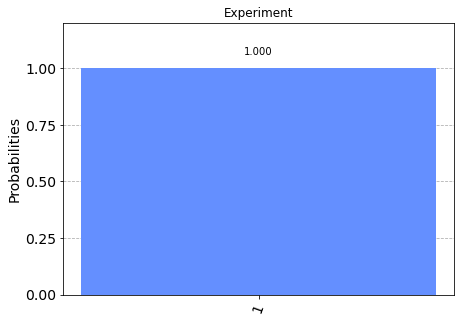

In [10]:
import math
simulator = Aer.get_backend('qasm_simulator')

nSize = int(math.log(2,2))
print(nSize)
circuit = generateCircuitContinuoslyNeuron(nSize,  [2.513, 2.513],  [0.628, 0.628])
result = execute(circuit, simulator, shots=8192).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Experiment')

In [67]:
w0 =  [0.5, 0.5] 
xs = [[-1, -1],  [-1,1], [1,1], [1,-1]]
ys = [1,0,1,0]

xs = [[-1, -1]]
ys = [1]

y_train = 1
lrParameter=0.1
thresholdParameter=0.3

menorErro = realizaTreinamento(xs=xs, 
                   ys=ys, 
                   w0=w0, 
                   taxaAprendizado=lrParameter,
                   taxaDeLimiar=thresholdParameter, 
                   estrategiaDeCarregamentoEntrada=3,
                   qtdeIteracoes=1000)

print("menor erro", menorErro)

menor erro (0, [(1, 1)], 13)


In [ ]:
pesosaleatorios = [[random.random(), random.random()] for i in range(10)]
print(pesosaleatorios)
limiares = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
txaprendizado = [0.1, 0.3, 0.5]

w0 =  [0.5, 0.5] 
xs = [[-1, -1],  [-1,1], [1,1], [1,-1]]
ys = [1,0,1,0]
y_train = 1
lrParameter=0.1
thresholdParameter=0.3

print("\n\n")
print("iniciando experimentos...")
print("\n\n")


for lrParameter in txaprendizado:
    print("lrParameter", lrParameter)
    for thresholdParameter in limiares:
        print("thresholdParameter", thresholdParameter)
        for w0 in pesosaleatorios:
            print("peso", w0)
            for estrategia in [0,1,2,3,4]:
                menorErro = realizaTreinamento(xs=xs, 
                                   ys=ys, 
                                   w0=w0[::],  
                                   taxaAprendizado=lrParameter,
                                   taxaDeLimiar=thresholdParameter, 
                                   estrategiaDeCarregamentoEntrada=estrategia,
                                   qtdeIteracoes=1000)

                print("estrategia", estrategia, "menor erro: ", menorErro)

[[0.61185894056357, 0.11373749151009693], [0.8021300546286646, 0.6448862039327424], [0.8104607209914071, 0.28925221327305795], [0.18788721771804873, 0.0709942947733534], [0.3892882132980222, 0.1842257387610824], [0.9932389861006539, 0.3775192641362619], [0.658260787338697, 0.6300393874090716], [0.7857606282304852, 0.8094599152332255], [0.6209211345127874, 0.4198370234643206], [0.9524793693380046, 0.6830925845067795]]



iniciando experimentos...



lrParameter 0.1
thresholdParameter 0.1
peso [0.61185894056357, 0.11373749151009693]
estrategia 0 menor erro:  (2, [(1, 1), (1, 0), (1, 1), (1, 0)], 13)
estrategia 1 menor erro:  (0, [(1, 1), (0, 0), (1, 1), (0, 0)], 13)
estrategia 2 menor erro:  (0, [(1, 1), (0, 0), (1, 1), (0, 0)], 13)
estrategia 3 menor erro:  (0, [(1, 1), (0, 0), (1, 1), (0, 0)], 13)
estrategia 4 menor erro:  (2, [(1, 1), (1, 0), (1, 1), (1, 0)], 7)
peso [0.8021300546286646, 0.6448862039327424]
estrategia 0 menor erro:  (2, [(1, 1), (1, 0), (1, 1), (1, 0)], 13)
estrategia